# Problem Set 5, due June 2nd 11:59pm (end of day).

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download pset5.ipynb and the file "reviews.csv" from Canvas.

I suggest you to get familiar with 'groupby' and
_unique_ functions in 'numpy'.  You will probably also need
_CountVectorizer_ in 'sklearn.feature\_extraction.text' and
_MultinomialNB_ in 'sklearn.naive\_bayes'


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os


# Introduction

In this assignment, you'll be analyzing movie reviews in an attempt to
determine whether movies are good or bad.  The file "reviews.csv",
contains reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh or Rotten.

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As before, we'll start out with some exploratory data analysis.

# 1 Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data, either missing review or missing fresh/rotten indicator.

In [2]:
#Reviews DataSet
reviews_df = pd.read_csv('reviews.csv')
reviews_df.isnull().sum()

critic         705
fresh            0
imdb             0
link             0
publication      0
quote            0
review_date      0
rtid             0
title            0
dtype: int64

In [3]:
#Movies DataSet
movies_df = pd.read_table('movies.dat')
movies_df.isnull().sum()

id                          0
title                       0
imdbID                      0
spanishTitle                0
imdbPictureURL            176
year                        0
rtID                      297
rtAllCriticsRating          0
rtAllCriticsNumReviews      0
rtAllCriticsNumFresh        0
rtAllCriticsNumRotten       0
rtAllCriticsScore           0
rtTopCriticsRating          0
rtTopCriticsNumReviews      0
rtTopCriticsNumFresh        0
rtTopCriticsNumRotten       0
rtTopCriticsScore           0
rtAudienceRating            0
rtAudienceNumRatings        0
rtAudienceScore             0
rtPictureURL                0
dtype: int64

In [4]:
#Dropping missing data
reviews_df = reviews_df.dropna()
movies_df = movies_df.dropna()

## 1.1 Basic features of the dataset

Answer the following questions by having your code directly print the
answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [5]:
# enter your code below

print ("Number of Unique Quotes:" ,len(reviews_df.quote.unique()))
print ("Number of Unique Critics:" ,len(reviews_df.critic.unique()))
print ("Number of Unique Movies in Reviews Dataset:" ,len(reviews_df.title.unique()))
print ("Number of Unique Movies in Movies Dataset:" ,len(movies_df.title.unique()))
print ("Number of Unique Publications in Reviews Dataset:" ,len(reviews_df.publication.unique()))

('Number of Unique Quotes:', 12167)
('Number of Unique Critics:', 540)
('Number of Unique Movies in Reviews Dataset:', 1715)
('Number of Unique Movies in Movies Dataset:', 8959)
('Number of Unique Publications in Reviews Dataset:', 64)


## 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

Does the distribution look normal?  Is it what you expect?

In [6]:
# Forming a dataframe for number of reviews per reviewer
n_reviews_df = reviews_df['quote'].groupby(reviews_df['critic']).count().reset_index()
n_reviews_df.columns = ['Reviewer', 'Number_of_Reviews']
n_reviews_df.head()

,Reviewer,Number_of_Reviews
0,A.D. Murphy,14
1,A.H. Weiler,17
2,A.O. Scott,10
3,Aaron Hillis,2
4,Abel Green,5


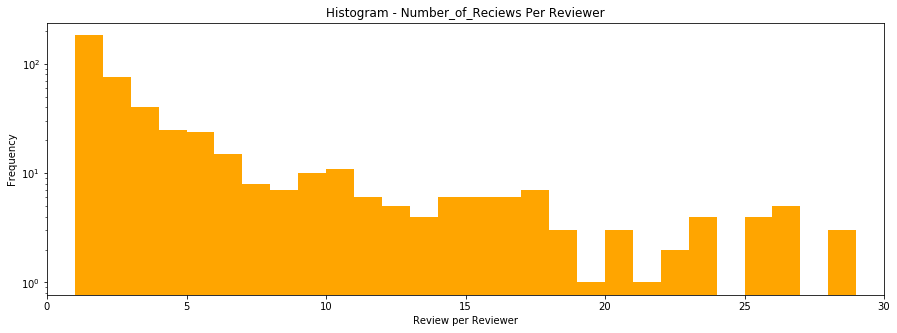

In [7]:
#Plotting the Distribution
fig,ax= plt.subplots(nrows=1)
ax.hist(n_reviews_df['Number_of_Reviews'], bins=range(30), color='orange')
fig.set_size_inches(15,5)
ax.set_yscale('log')
ax.set_xlim(0, 30)

#Lables
ax.set_title('Histogram - Number_of_Reciews Per Reviewer')
ax.set_xlabel('Review per Reviewer')
ax.set_ylabel('Frequency')

The distribution of the of number of reviews is not normal, and its expected. Since its a count/number, the distribution is poisson.

## 1.3 Take a closer look of a few reviews

Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function*

In [8]:
# Most reviews
grouped_reviews = reviews_df.groupby([reviews_df['critic'],reviews_df['publication']])
grouped_df = grouped_reviews.agg({'quote':np.count_nonzero,'review_date' : [np.min, np.max]})
grouped_df = grouped_df.sort_values([('quote', 'count_nonzero')], ascending=False)[:30]

grouped_df.drop('quote', axis=1)

review_date  \
                                                           amin   
critic             publication                                    
Roger Ebert        Chicago Sun-Times        2000-01-01 00:00:00   
James Berardinelli ReelViews                1800-01-01 00:00:00   
Janet Maslin       New York Times           2000-01-01 00:00:00   
Variety Staff      Variety                  2001-02-13 00:00:00   
Jonathan Rosenbaum Chicago Reader           1988-07-11 00:00:00   
Desson Thomson     Washington Post          2000-01-01 00:00:00   
Geoff Andrew       Time Out                 2005-08-11 00:00:00   
Dave Kehr          Chicago Reader           2000-01-01 00:00:00   
Kenneth Turan      Los Angeles Times        2000-01-01 00:00:00   
Mick LaSalle       San Francisco Chronicle  2000-01-01 00:00:00   
Owen Gleiberman    Entertainment Weekly     1800-01-01 00:00:00   
Rita Kempley       Washington Post          2000-01-01 00:00:00   
Todd McCarthy      Variety                  2000-01-01 00:00:00   
Joe Baltake        Sacramento Bee           2000-01-01 00:00:00   
Vincent Canby      New York Times           2000-01-01 00:00:00   
Hal Hinson         Washington Post          2000-01-01 00:00:00   
Susan Stark        Detroit News             2000-01-01 00:00:00   
Stephen Holden     New York Times           2000-01-01 00:00:00   
Derek Adams        Time Out                 2006-01-26 00:00:00   
Kevin Thomas       Los Angeles Times        2000-01-01 00:00:00   
Peter Stack        San Francisco Chronicle  2000-01-01 00:00:00   
Bosley Crowther    New York Times           2000-01-01 00:00:00   
Rick Groen         Globe and Mail           2002-03-19 00:00:00   
Edward Guthmann    San Francisco Chronicle  2000-01-01 00:00:00   
Lisa Schwarzbaum   Entertainment Weekly     1979-01-01 00:00:00   
Liam Lacey         Globe and Mail           2001-08-24 00:00:00   
Emanuel Levy       Variety                  2000-01-01 00:00:00   
Richard Schickel   TIME Magazine            2007-06-27 00:00:00   
Richard Corliss    TIME Magazine            2003-12-16 00:00:00   
Jay Boyar          Orlando Sentinel         2002-01-03 00:00:00   

                                                                 
                                                           amax  
critic             publication                                   
Roger Ebert        Chicago Sun-Times        2013-06-11 00:00:00  
James Berardinelli ReelViews                2012-02-07 00:00:00  
Janet Maslin       New York Times           2010-09-07 00:00:00  
Variety Staff      Variety                  2012-08-15 00:00:00  
Jonathan Rosenbaum Chicago Reader           2013-10-22 00:00:00  
Desson Thomson     Washington Post          2012-10-08 00:00:00  
Geoff Andrew       Time Out                 2012-04-05 00:00:00  
Dave Kehr          Chicago Reader           2013-11-06 00:00:00  
Kenneth Turan      Los Angeles Times        2013-10-05 00:00:00  
Mick LaSalle       San Francisco Chronicle  2009-11-25 00:00:00  
Owen Gleiberman    Entertainment Weekly     2011-09-07 00:00:00  
Rita Kempley       Washington Post          2013-11-02 00:00:00  
Todd McCarthy      Variety                  2012-10-09 00:00:00  
Joe Baltake        Sacramento Bee           2004-12-22 00:00:00  
Vincent Canby      New York Times           2013-07-29 00:00:00  
Hal Hinson         Washington Post          2013-06-26 00:00:00  
Susan Stark        Detroit News             2002-10-25 00:00:00  
Stephen Holden     New York Times           2009-02-06 00:00:00  
Derek Adams        Time Out                 2009-10-04 00:00:00  
Kevin Thomas       Los Angeles Times        2013-11-02 00:00:00  
Peter Stack        San Francisco Chronicle  2002-06-18 00:00:00  
Bosley Crowther    New York Times           2008-05-06 00:00:00  
Rick Groen         Globe and Mail           2009-08-14 00:00:00  
Edward Guthmann    San Francisco Chronicle  2003-04-04 00:00:00  
Lisa Schwarzbaum   Entertainment Weekly     2012-08-15 00:

## 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in red showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

y=-0.010346x+(25.701699)


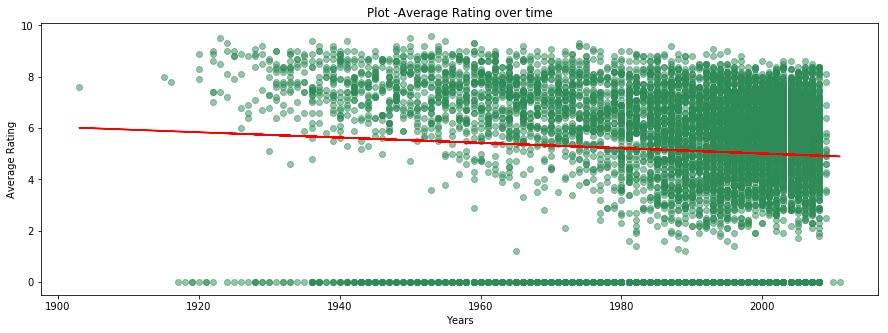

In [9]:
# extracting data from the movies dataset
years = movies_df['year']
ratings = movies_df['rtAllCriticsRating'].astype(float)

fig,ax= plt.subplots(nrows=1)
ax.scatter(years,ratings, alpha=0.5, color='seagreen')
fig.set_size_inches(15,5)

#Calculate the trend line
z = np.polyfit(years, ratings, 1)
p = np.poly1d(z)
ax.plot(years,p(years),"r-")

# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

#Lables
ax.set_title('Plot -Average Rating over time')
ax.set_xlabel('Years')
ax.set_ylabel('Average Rating')

Yes, there is a trend in the movies average rating over the years. The average ratings decrease with time. This could either mean that the movies quality decreased with time or the critics became stricter with time.

# Part 2: Naive Bayes

Now it gets fun!  You are going to use a Naive Bayes classifier to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. 

## 2.0 Using CountVectorizer

One thing that may help you in the following problems is the _CountVectorizer_ object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in the text.  (Note: the order of wordss is not preserved in the bag).   Here's a simple example, make sure you understand what's going on!

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

sentences = ["Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.", "When I joined them, as usual they said go away.", "Will not.", "This yard's as much mine as it is your, Jem Finch.", "I got just as much right to play in it as you have."]
# Harper Lee "To Kill a Mockingbrid"
print "Original text:\n", '\n'.join(sentences)

vectorizer = CountVectorizer(min_df=0)
vectorizer.fit(sentences)
# `fit` builds the vocabulary
x = vectorizer.transform(sentences).toarray()
# `transform` converts text to a bag of words
print "Transformed text vector:\n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print "Words for each feature:"
print vectorizer.get_feature_names()

Original text:
Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.
When I joined them, as usual they said go away.
Will not.
This yard's as much mine as it is your, Jem Finch.
I got just as much right to play in it as you have.
Transformed text vector:
[[1 0 1 0 1 1 1 1 0 1 0 0 0 2 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0
  0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0
  0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
  0]
 [0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
  1]
 [0 2 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1
  0]]
Words for each feature:
[u'and', u'as', u'awakened', u'away', u'back', u'conversation', u'deep', u'dill', u'finch', u'found', u'go', u'got', u'have', u'in', u'is', u'it', u'jem', u'joined', u'just', u'mine', u'morning', u'much', u'next', u'not', u'play', u'right', u'said', u'the', u'them', u'they', u'th

## 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row is the bag-of-words representation for a single review.  This will be the *input* (fetaures) of your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* (target) from your model.
 
 Make sure to remove items with no review text

Feel free to use the _make\_xy_ function below to achieve it, but you can also create your own parser.

In [11]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y

In [12]:
#Calling the function
X, Y = make_xy(reviews_df)

In [13]:
X.shape, Y.shape

((12737, 20281), (12737L,))

## 2.2 Test-Train split

Next, randomly split the data into two groups: a training (75%) set and a validation set (25%).  You can do this manually, as you have done earlier, but I recommend to use `train_test_split` in 'sklearn.model_selection'.

In [14]:
# enter your code here
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [15]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((9552, 20281), (9552L,), (3185, 20281), (3185L,))

## 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the `MultinomialNB` from 'sklearn'.  Play with _MultinomialNB_ parameters.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [16]:
# enter your code here
import sklearn.naive_bayes as nb
from sklearn.metrics import accuracy_score

In [17]:
#Multinomial NB
clf = nb.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
#Fitting Training data
fit_1 = clf.fit(X_train, Y_train)
#Predictions
pred_1 = clf.predict(X_test)
#Accuracy Report
print accuracy_score(pred_1,Y_test)

0.781789638932


In [18]:
#Manipulating the Parameters - alpha =2.5, fit_prior=False
#Multinomial NB
clf_2 = nb.MultinomialNB(alpha=2.5, fit_prior=False, class_prior=None)
#Fitting Training data
fit_2 = clf_2.fit(X_train, Y_train)
#Predictions
pred_2 = clf_2.predict(X_test)
#Accuracy Report
print accuracy_score(pred_2,Y_test)

0.763265306122


## 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!

That was almost too easy, right?  Right.

Your next mission, if you feel you want to take an extra challenge, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:** Do this *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [19]:
# Your code here

# 3 Evaluation

## 3.1 Estimate the likelihood of your data

Calculate log-likelihood of a fitted model.  Log-likelihood is a way to assess the performance of your model.  Remeber -- likelihood is more-or-less the probability to observe your data (including your target).  Below is an example function that calculates the log-likelihood of an estimated model using `fitted_model.predict_logproba`.  You may use this function, or write your own.  

In [20]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 

The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews.

Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    # returns Nx2 array.  Columns are log(Pr(y == 0|x)), log(Pr(y==1|x))
    ll = prob[y == 0, 0].sum() + prob[y == 1, 1].sum()
    return ll



In [21]:
np.unique(X.data)

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10], dtype=int64)

In [22]:
log_likelihood(fit_1, X, Y)

-3516.2206002150779

In [23]:
log_likelihood(fit_2, X, Y)

-4587.8714715972137

## 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The `alpha` keyword in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

We are going to use cross-validation to tune these hyperparameters.  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.model_selection.cross_val_score`, that might save you a lot of time here...*

In [24]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

def cross_validation(alphas,min_dfs):
    result_master = []
    for m in min_dfs:
        vect = CountVectorizer(min_df=m)
        X,Y = make_xy(reviews_df, vectorizer=vect)
        for a in alphas:
            model = nb.MultinomialNB(alpha=a, fit_prior=True, class_prior=None)
            #Fitting Training data
            fit = model.fit(X,Y)
            scores = [(cross_val_score(fit, X, Y, cv=10, scoring=log_likelihood))]
            dict1 = ({'a':a,'score':np.mean(scores), 'm':m})
            result_master.append(dict1)
            df1 = pd.DataFrame(result_master)
            df2 = (df1.sort_values('score', ascending=False)).iloc[0]
    return df2

In [25]:
cross_validation(alphas,min_dfs)

D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
D:\Anaconda\lib\site-packages\sklearn\utils\extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))


a          5.000000
m          0.001000
score   -693.688643
Name: 15, dtype: float64

We can see from above results that for min_df=0.001 and alpha = 5, we get the max log likelihood of -693.68.

## 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [26]:
#Defining Vectorizer
vect2 = CountVectorizer(min_df=0.001)
#Making X and Y
X,Y = make_xy(reviews_df, vectorizer=vect2)
#Splitting the data into train and test
# enter your code here
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
#Multinomial NB
model = nb.MultinomialNB(alpha=5, fit_prior=True, class_prior=None)
#Fitting Training data
fit = model.fit(X_train, Y_train)
#Predictions
predictions = model.predict(X_test)
#Accuracy Reportf
from sklearn.metrics import accuracy_score
print accuracy_score(predictions,Y_test)

0.750392464678


Cross Validation helped us find an optimum value for alpha and minumum. This improved the accuracy of the model from 72% to 74%. Also, Overfitting of the model is now fits wellbetter. 

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [27]:
# Cross Validation - Classification Accuracy

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

def cross_validation(alphas,min_dfs):
    result_master = []
    for m in min_dfs:
        vect = CountVectorizer(min_df=m)
        X,Y = make_xy(reviews_df, vectorizer=vect)
        for a in alphas:
            model = nb.MultinomialNB(alpha=a, fit_prior=True, class_prior=None)
            #Fitting Training data
            fit = model.fit(X,Y)
            scores = [(cross_val_score(model, X, Y, cv=10, scoring='accuracy'))]
            dict1 = ({'a':a,'score':np.mean(scores), 'm':m})
            result_master.append(dict1)
            df1 = pd.DataFrame(result_master)
            df2 = (df1.sort_values('score', ascending=False)).iloc[0]
    return df2

In [28]:
cross_validation(alphas,min_dfs)

a        1.000000
m        0.000010
score    0.769491
Name: 2, dtype: float64

When we use classification accuracy, the model is further improved and alpha is now 1, min_df=0.00001.

## 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [29]:
# Enter your code here
# Take a look at the words in the vocabulary
vocab = np.asarray(vect2.get_feature_names())

#Testing
test = np.eye(X_test.shape[1])

probs = model.predict_log_proba(test)[:, 0]

ind = np.argsort(probs)

good_words = vocab[ind[:10]]
bad_words = vocab[ind[-10:]]

good_prob = 1 - np.exp(probs[ind[:10]])
bad_prob = 1 - np.exp(probs[ind[-10:]])

In [30]:
#Results
result_df = pd.DataFrame({'Fresh_Review_Words':good_words, 'Rotten_Review_Words':bad_words,
                          'Fresh_Review_Probability':good_prob, 'Rotten_Review_Probability':bad_prob})
result_df

,Fresh_Review_Probability,Fresh_Review_Words,Rotten_Review_Probability,Rotten_Review_Words
0,0.878027,masterpiece,0.246537,sadly
1,0.870149,delight,0.243668,fails
2,0.868360,intelligent,0.239032,disappointment
3,0.866933,rare,0.230271,dull
4,0.866520,remarkable,0.200827,unfunny
5,0.860452,witty,0.199551,pointless
6,0.859310,touching,0.179074,uninspired
7,0.856799,succeeds,0.173151,bland
8,0.854302,engrossing,0.148581,lame
9,0.852045,beautifully,0.135739,unfortunately


###3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [31]:
#Your code here
x, y = make_xy(reviews_df, vect2)
probabilities = model.predict_proba(x)[:,0]
predictions = model.predict(x)
misclassified_rotten = np.argsort(probabilities[y == 0])[:5]
misclassified_fresh = np.argsort(probabilities[y == 1])[-5:]

In [32]:
#Results
fresh_review_quotes = []
rotten_review_quotes = []
for i in misclassified_rotten:
    rotten_review_quotes.append(reviews_df[y == 0].quote.irow(i))
for j in misclassified_rotten:
    fresh_review_quotes.append(reviews_df[y == 1].quote.irow(j))
    
#Stroring results in a dataframe
df = pd.DataFrame({'Misclassified_fresh_review_quotes':fresh_review_quotes,
                   'Misclassified_rotten_review_quotes':rotten_review_quotes})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]
  import sys


In [33]:
df

,Misclassified_fresh_review_quotes,Misclassified_rotten_review_quotes
0,An exemplary version of Frances Hodgson Burnet...,"Nava, who started his feature-film career with..."
1,It's a perfect motion picture roller coaster -...,It survives today only as an unusually pure ex...
2,"It looks fantastic, sounds great, and the 3-D ...","It's a sad day when an actor who's totally, be..."
3,"[A] handsome, deeply felt, even more deeply re...","The hip, smart yarn has a bite not seen in Ame..."
4,"powerful experience, alternately corrosive wit...",The Waterboy is arguably Sandler's most enjoya...


As we can see in the above review quotes, the features(words) used to train our model to classify fresh or rotten reviews is positive for fresh reviews and negative for rotten reviews. If positive words are used in a rotten review, then our classifier misclassifies it. Similarly, if negative words or words not used in our feature space are used in a fresh review, there is misclassification.

##Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [34]:
from sklearn.datasets import load_boston
bdata = load_boston()

###4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

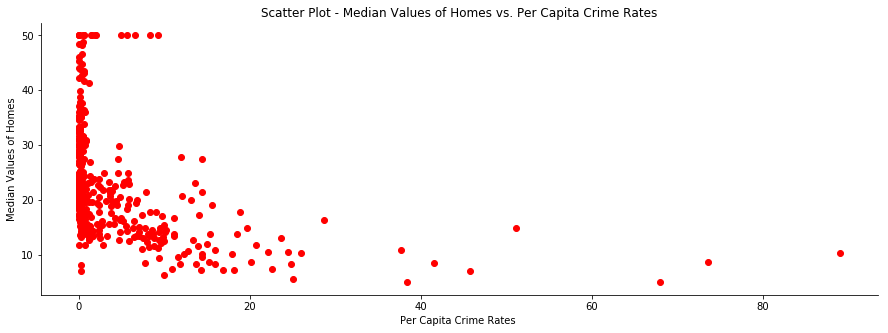

In [35]:
# Enter your code here
#Plot
fig,ax= plt.subplots(nrows=1)
fig.set_size_inches(15,5)
ax.scatter(bdata.data[:,0],bdata.target, color='red')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Lables
ax.set_title('Scatter Plot - Median Values of Homes vs. Per Capita Crime Rates')
ax.set_xlabel('Per Capita Crime Rates ')
ax.set_ylabel('Median Values of Homes')


In [36]:
# reset data as pandas DataFrame
boston_df = pd.DataFrame(bdata.data)

# label columns
boston_df.columns = bdata.feature_names

#Add the target of the boston data set, the price. We'll create a new column in our DataFrame
boston_df['Price'] = bdata.target

from statsmodels.formula.api import ols
#(a) regressing the housing price on the number of rooms per house
#Linear model
lm_fit1= ols(formula='Price ~ RM', data=boston_df).fit()

#Summary of the fitted model
lm_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Fri, 02 Jun 2017   Prob (F-statistic):           2.49e-74
Time:                        14:22:10   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.000     -39.877     -29.465
RM             9.1021      0.419     21.722      0.000       8.279       9.925
==============================================================================
Omnibus:                      102.585   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.449
Skew:                           0.726   Prob(JB):                    1.02e-133
Kurtosis:                       8.190   Cond. No.                         58.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.08
"""

def compute_rmse(predictions,y_values):
    sq_error = (predictions - y_values)**2
    sum_sq_error = sq_error.sum()
    rmse = math.sqrt(sum_sq_error/float(len(predictions)))
    return rmse

In [38]:
import math
#Adding the target column into the boston data
bdata_with_target= np.insert(bdata.data, bdata.data.shape[1],bdata.target, axis = 1)

#Setting the seed and randomly shuffling the data
np.random.seed(seed=13579)
random_bdata = np.random.shuffle(bdata_with_target)


#Slicing 66% of the random data for training set and 34% for test set.
train_row_num = int(math.ceil(0.66*len(bdata_with_target)))


#Splitting the data
bdata_train = bdata_with_target[0:train_row_num,:]
bdata_test = bdata_with_target[train_row_num:len(bdata_with_target),:]

#Creating a function to compute RMSEs on the baseline prediction model

#Predicted values for training will be the mean of the training_Set's target
pred_training = bdata_train[:,13].mean()
    
#Using the training model for predicting values for test data too
pred_test = bdata_train[:,13].mean()
    
#Calculate RMSE on both training and test sets
rmse_training = compute_rmse(bdata_train[:,13], pred_training)
rmse_test = compute_rmse(bdata_test[:,13], pred_test)

#Store the Results in a Dataframe
results_df = pd.DataFrame([{"pred_training":pred_training, 
                            'pred_test':pred_test,
                            'rmse_test': rmse_test,
                            'rmse_training': rmse_training,}])
results_df

,pred_test,pred_training,rmse_test,rmse_training
0,22.045808,22.045808,10.309262,8.574434


###4.2 So many scatterplots!

Choose 8 out of the of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

In [39]:
boston_df_8 = boston_df.ix[:,0:7]
boston_df_8['Price'] = boston_df.loc[:,'Price']

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
boston_df_8.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,36.2


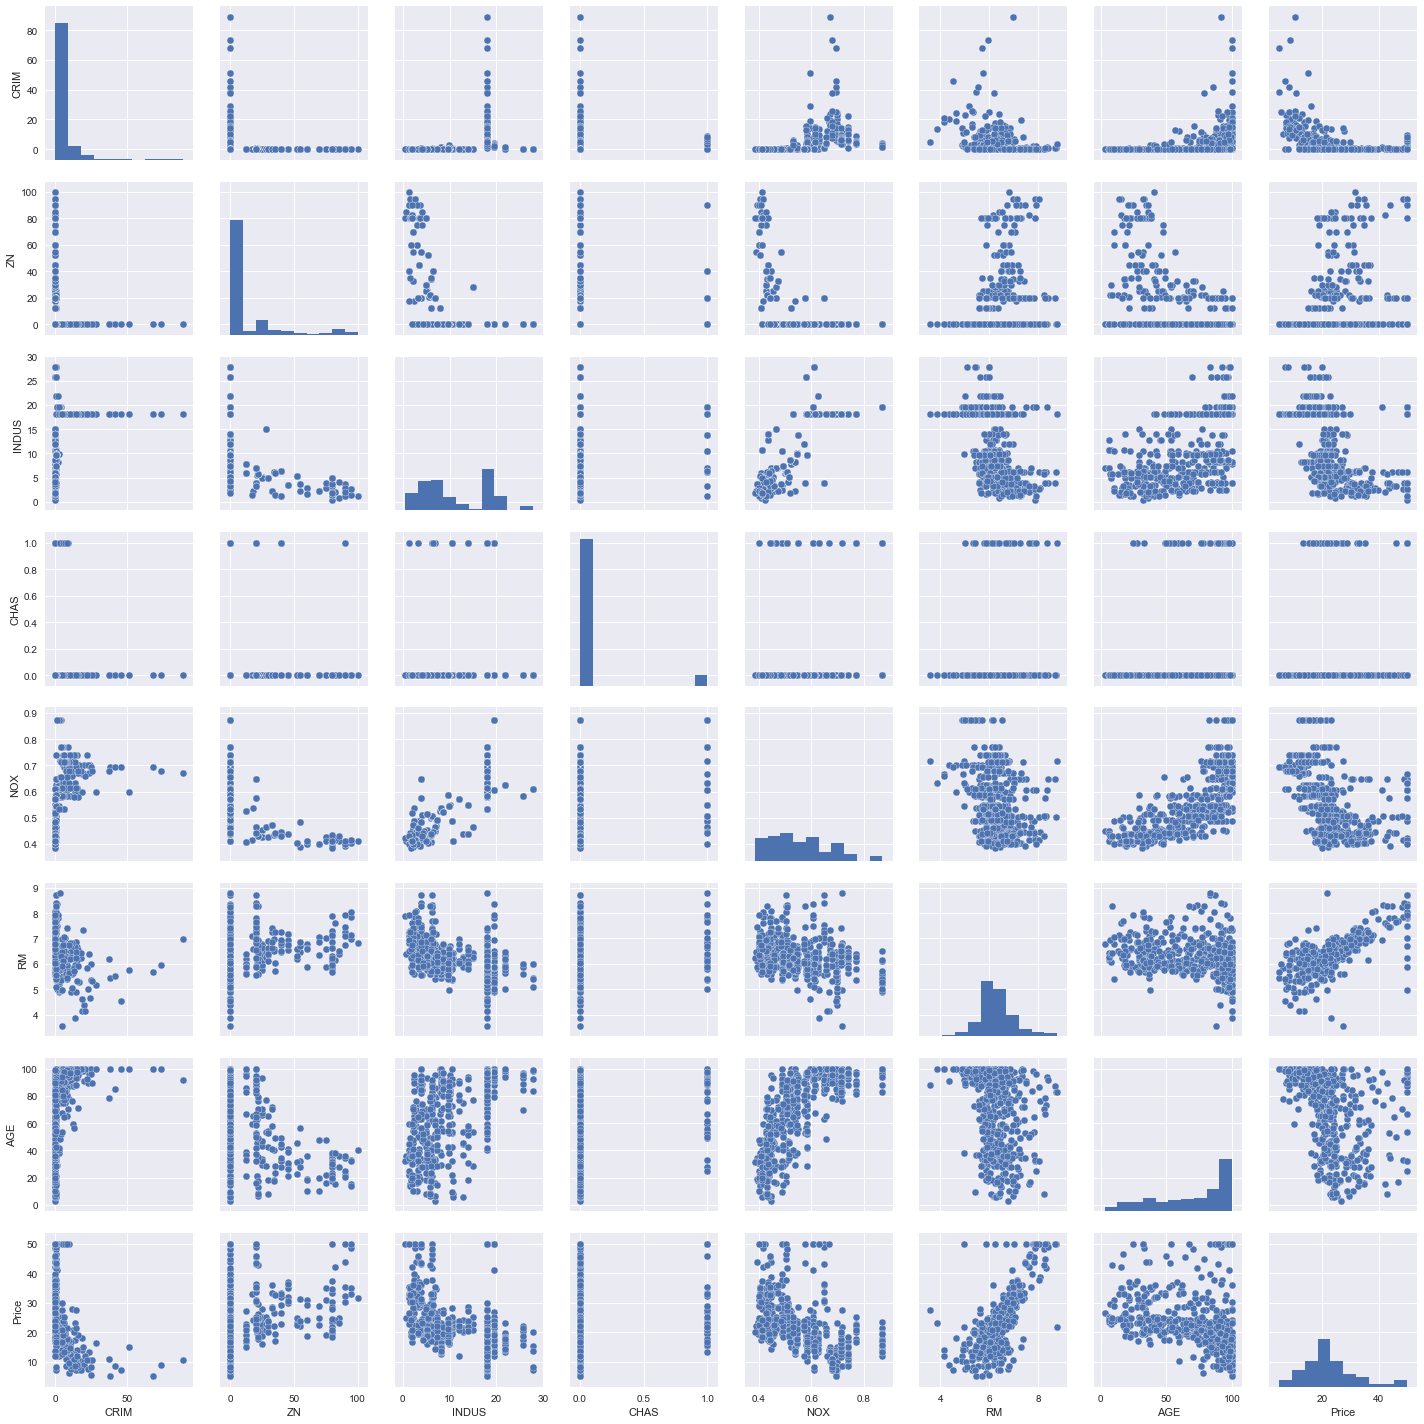

In [41]:
import seaborn as sns
sns.set()

sns.pairplot(boston_df_8)

###4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

In [42]:
# Enter your code here
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca.fit(bdata_train)

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
var_explained = pca.explained_variance_ratio_
no_components = range(len(var_explained))

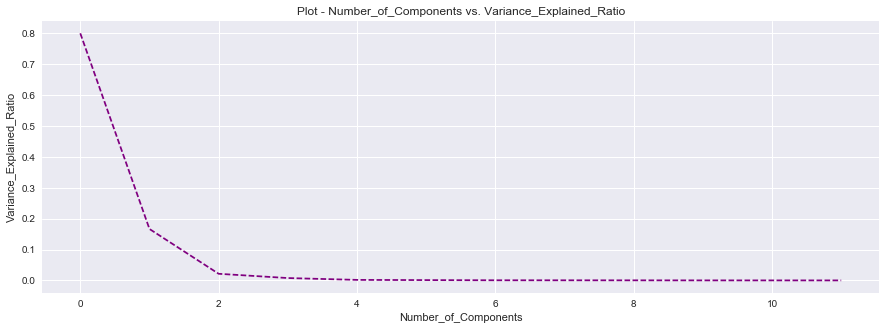

In [44]:
#Plot
fig,ax= plt.subplots(nrows=1)
fig.set_size_inches(15,5)
ax.plot(no_components,var_explained, color='purple',linestyle='--')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Lables
ax.set_title('Plot - Number_of_Components vs. Variance_Explained_Ratio')
ax.set_xlabel('Number_of_Components')
ax.set_ylabel('Variance_Explained_Ratio')

###4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

In [45]:
#PCA 2
pca_2 = PCA(n_components=2)
pca_2.fit(bdata_train)
bdata_train_2 = pca_2.transform(bdata_train)

df_2D = pd.DataFrame(bdata_train_2,columns=['PCA1', 'PCA2'])
df_2D['Price'] = boston_df['Price']
df_2D.head()

,PCA1,PCA2,Price
0,235.583749,-124.715969,24.0
1,-134.895733,6.408589,21.6
2,-132.719003,8.762804,34.7
3,-77.538554,26.259557,33.4
4,-7.005126,-19.422553,36.2


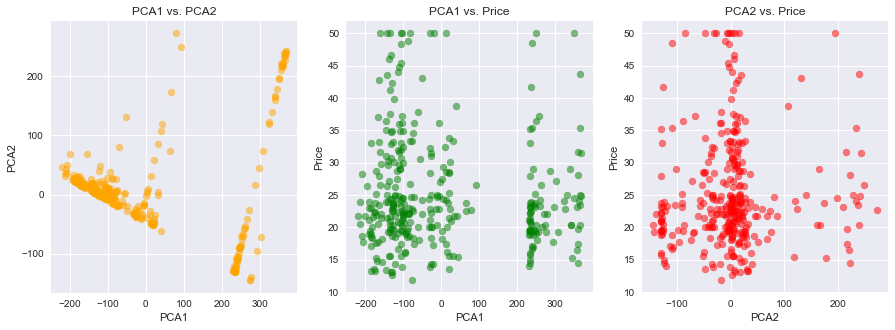

In [46]:
fig,(ax1, ax2,ax3)= plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(15,5)
#PCA1 vs. PCA2
ax1.scatter(df_2D['PCA1'],df_2D['PCA2'], color='orange', alpha=0.5)

#Lables
ax1.set_title('PCA1 vs. PCA2')
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')

#PCA1 vs. Price
ax2.scatter(df_2D['PCA1'],df_2D['Price'], color='green', alpha=0.5)

#Lables
ax2.set_title('PCA1 vs. Price')
ax2.set_xlabel('PCA1')
ax2.set_ylabel('Price')

#PCA1 vs. Price
ax3.scatter(df_2D['PCA2'],df_2D['Price'], color='red', alpha=0.5)

#Lables
ax3.set_title('PCA2 vs. Price')
ax3.set_xlabel('PCA2')
ax3.set_ylabel('Price')

###4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [47]:
#Projecting all data on 1 Principal component

pca_1 = PCA(n_components=1)
pca_1.fit(bdata_train)
bdata_train_1 = pca_1.transform(bdata_train)

bdata_with_target_transformed = pca_1.transform(bdata_with_target)

In [48]:
#Fitting Regression on this data

# reset data as pandas DataFrame
X_pca = pd.DataFrame(bdata_with_target_transformed,columns=['PCA1'])
#Add the target of the boston data set, the price. We'll create a new column in our DataFrame
Y_pca = pd.DataFrame(bdata.target,columns=['Price'])

#Splitting training and test
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_pca, Y_pca, test_size=0.33, random_state=42)

# Import for Linear Regression
import sklearn
from sklearn.linear_model import LinearRegression
# Create a LinearRegression Object
lreg = LinearRegression()
                     
lreg.fit(X_train_pca, Y_train_pca)

#Predict
predictions_test_pca = lreg.predict(X_test_pca)
predictions_train_pca = lreg.predict(X_train_pca)

#Compute RMSE
#Calculate RMSE on both training and test sets
rmse_training_pca = compute_rmse(np.asarray(predictions_train_pca), Y_train_pca)
rmse_test_pca = compute_rmse(np.asarray(predictions_test_pca), Y_test_pca)

#Store the Results in a Dataframe
results_pca_df = pd.DataFrame([{'rmse_test': rmse_test_pca,'rmse_training': rmse_training_pca}])
results_pca_df

,rmse_test,rmse_training
0,8.803292,9.373733


As can be seen above in 4.1, the test RMSE is more than training MSE, which shows we overfitted our data then. Here, the test RMSE is lower than training MSE, which shows the overfitting problem is reduced due to PCA. This means that maximum amount of variance in the boston house price data is explained by the 1st principal component.